In [2]:
import hydra
from omegaconf import OmegaConf
from glob import  glob
from rosa.data import  RosaDataModule, create_io_paths
from rosa.modeling import  RosaLightningModule


BASE_DIR = "/home/ec2-user/outputs/2023-03-14/19-24-09"
config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = BASE_DIR + "/checkpoints/epoch=*.ckpt"
    chkpt = glob(chkpts)[0]

    _, output_path = create_io_paths(config.paths)

    # Create Data Module
    rdm = RosaDataModule(
        output_path,
        config=config.data_module,
    )
    rdm.setup()

    # Load model from checkpoint
    rlm = RosaLightningModule.load_from_checkpoint(
        chkpt,
        var_input=rdm.var_input,
        config=config.module,
    )
    print(rlm)

# display(adata)
print(chkpt)

/tmp/ipykernel_18980/2676343603.py:11: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):
/home/ec2-user/rosa/rosa/data/datasets.py:107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mask[torch.tensor(mask).long()] = True


RosaLightningModule(
  (model): RosaTransformer(
    (main): Sequential(
      (dual_embed): ParallelEmbed(
        (models): ModuleList(
          (0): Sequential(
            (input_embed_0): MaskedEmbed(
              (model): Sequential(
                (projection): Embedding(17, 320)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
          (1): Sequential(
            (layer_norm_1): Identity()
            (input_embed_1): InputEmbed(
              (model): Sequential(
                (projection): Linear(in_features=3072, out_features=320, bias=True)
                (layer_norm): Identity()
                (dropout): Dropout(p=0, inplace=False)
              )
            )
          )
        )
      )
      (join_embeds): AddEmbeds()
    )
    (transformer): Performer(
      (net): SequentialSequence(
        (layers): ModuleList(
          (0): ModuleList(
            (0): PreLayerNorm(

In [9]:
rdm.val_dataset.transform[1].zero_bin

True

In [13]:
import torch

In [14]:
torch.unique(rdm.val_dataset[0]['expression'], return_counts=True)

(tensor([ 0, 10, 12, 13, 14, 15]),
 tensor([17272,  1336,   340,   154,   180,   149]))

In [15]:
rdm.val_dataset[0]

{'expression': tensor([0, 0, 0,  ..., 0, 0, 0]),
 'mask': tensor([False,  True,  True,  ..., False, False,  True]),
 'indices': tensor([    0,     1,     2,  ..., 19428, 19429, 19430]),
 'obs_idx': tensor(4)}

In [26]:
tensor = torch.Tensor(rdm.val_dataset.expression[4].toarray())

In [19]:
import numpy as np

In [32]:
val, counts = torch.unique(tensor, return_counts=True)

In [21]:
n_bins = 16

In [27]:
# Put all zero values in their own bin and then distribute others evenly
boundaries = torch.quantile(tensor[tensor>0], torch.linspace(0, 1, n_bins))
boundaries = torch.concat([torch.tensor([0]), boundaries])
boundaries[-1] = torch.inf
aa = torch.bucketize(tensor, boundaries, right=True) - 1
torch.unique(aa, return_counts=True)

In [39]:
# Put all zero values in their own bin and then distribute others evenly
boundaries = torch.quantile(tensor, torch.linspace(0, 1, n_bins))
ab = torch.bucketize(tensor, boundaries)
torch.unique(ab, return_counts=True)

(tensor([ 0, 14, 15]), tensor([17272,  1336,   823]))

In [43]:
boundaries = torch.quantile(tensor[tensor>0], torch.linspace(0, 1, n_bins - 1))
tmp = torch.bucketize(tensor[tensor>0], boundaries) + 1
new = torch.zeros_like(tensor).long()
new[tensor > 0] = tmp
torch.unique(new, return_counts=True)

(tensor([ 0,  1, 10, 12, 13, 14, 15]),
 tensor([17272,  1336,   340,   154,    73,   107,   149]))

In [49]:
torch.quantile(tensor, torch.linspace(0, 1, n_bins))

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1., 351.])

In [29]:
torch.unique(aa, return_counts=True)

(tensor([ 0, 10, 12, 13, 14, 15]),
 tensor([17272,  1336,   340,   154,   180,   149]))

In [30]:
boundaries

tensor([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2., 3., 4., 8., inf])

In [33]:
import matplotlib.pyplot as plt

(0.0, 50.0)

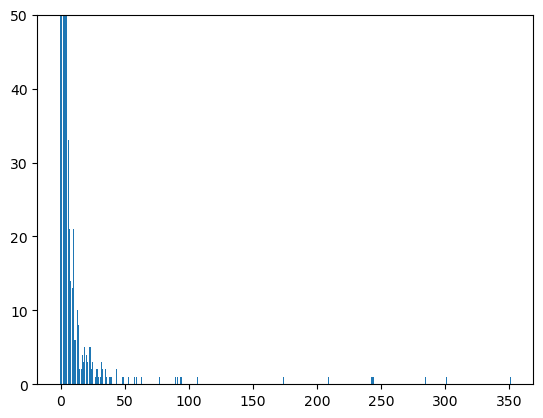

In [37]:
plt.bar(val, counts)
plt.ylim([0, 50]);

In [50]:
torch.quantile(tensor, torch.linspace(0, 1, n_bins))

tensor([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1., 351.])

In [90]:
torch.quantile(tensor, torch.logspace(0, .301, n_bins) - 1)

tensor([  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          1.0000, 256.9727])

In [89]:
torch.logspace(0, .301, n_bins) - 1

tensor([0.0000, 0.0473, 0.0968, 0.1487, 0.2030, 0.2599, 0.3195, 0.3819, 0.4472,
        0.5157, 0.5873, 0.6624, 0.7410, 0.8233, 0.9096, 0.9999])

In [66]:
10**2

100

In [3]:
from rosa.utils import score_predictions, plot_expression_and_correlation, plot_marker_gene_heatmap


adata_test, results = score_predictions(adata)

/Users/nsofroniew/opt/anaconda3/envs/multiomics/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4881: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))



        mean spearmanr across genes 0.698
        mean spearmanr across cells 0.214
        mean square error 0.651
        ks-statistic on total expression 0.208
        mean percent total expression captured per cell 65.647
        


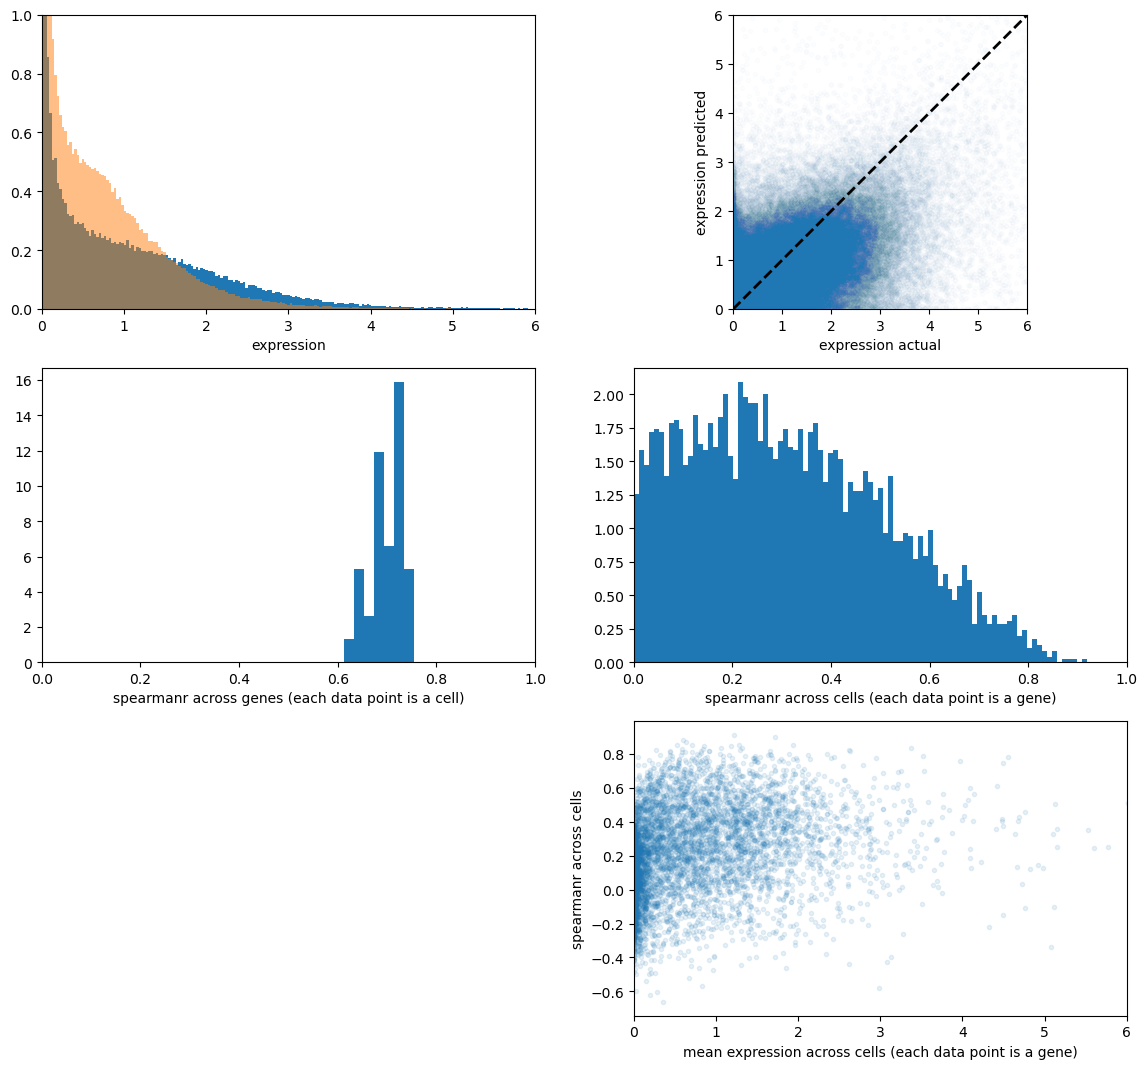

In [4]:
plot_expression_and_correlation(adata_test, results)

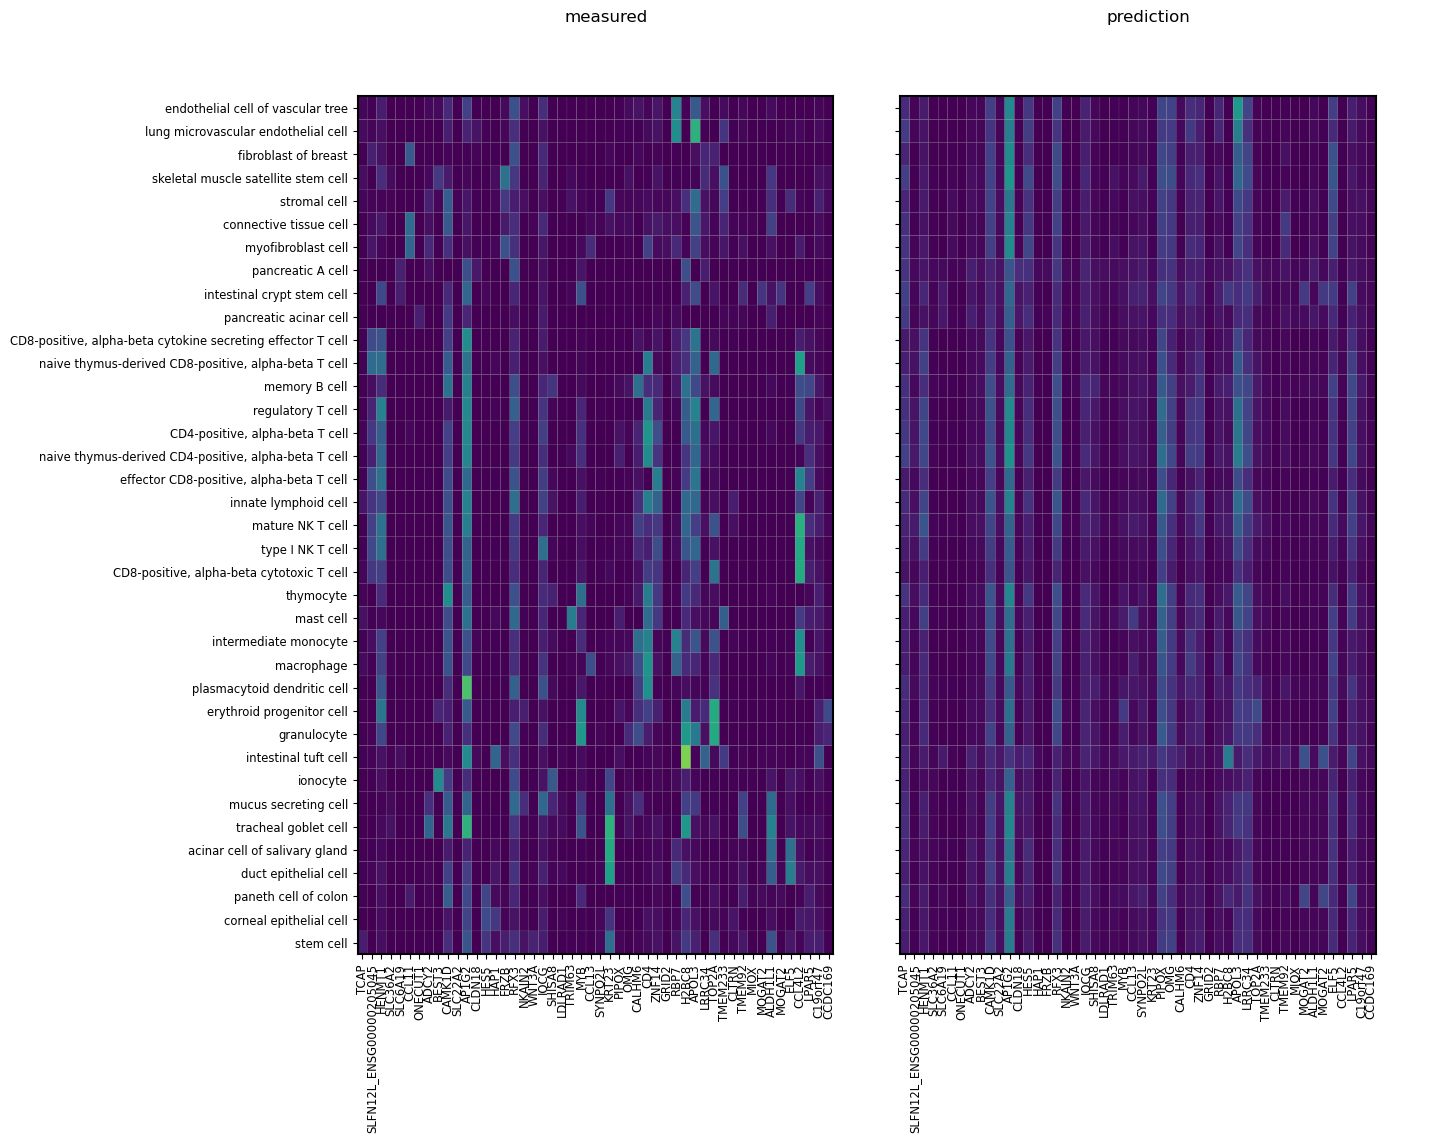

In [5]:
import numpy as np


marker_genes = adata_test.var[adata_test.var['highly_variable']]['feature_name'].values
np.random.seed(42)
marker_genes = np.random.choice(marker_genes, 50)

plot_marker_gene_heatmap(adata_test, marker_genes)

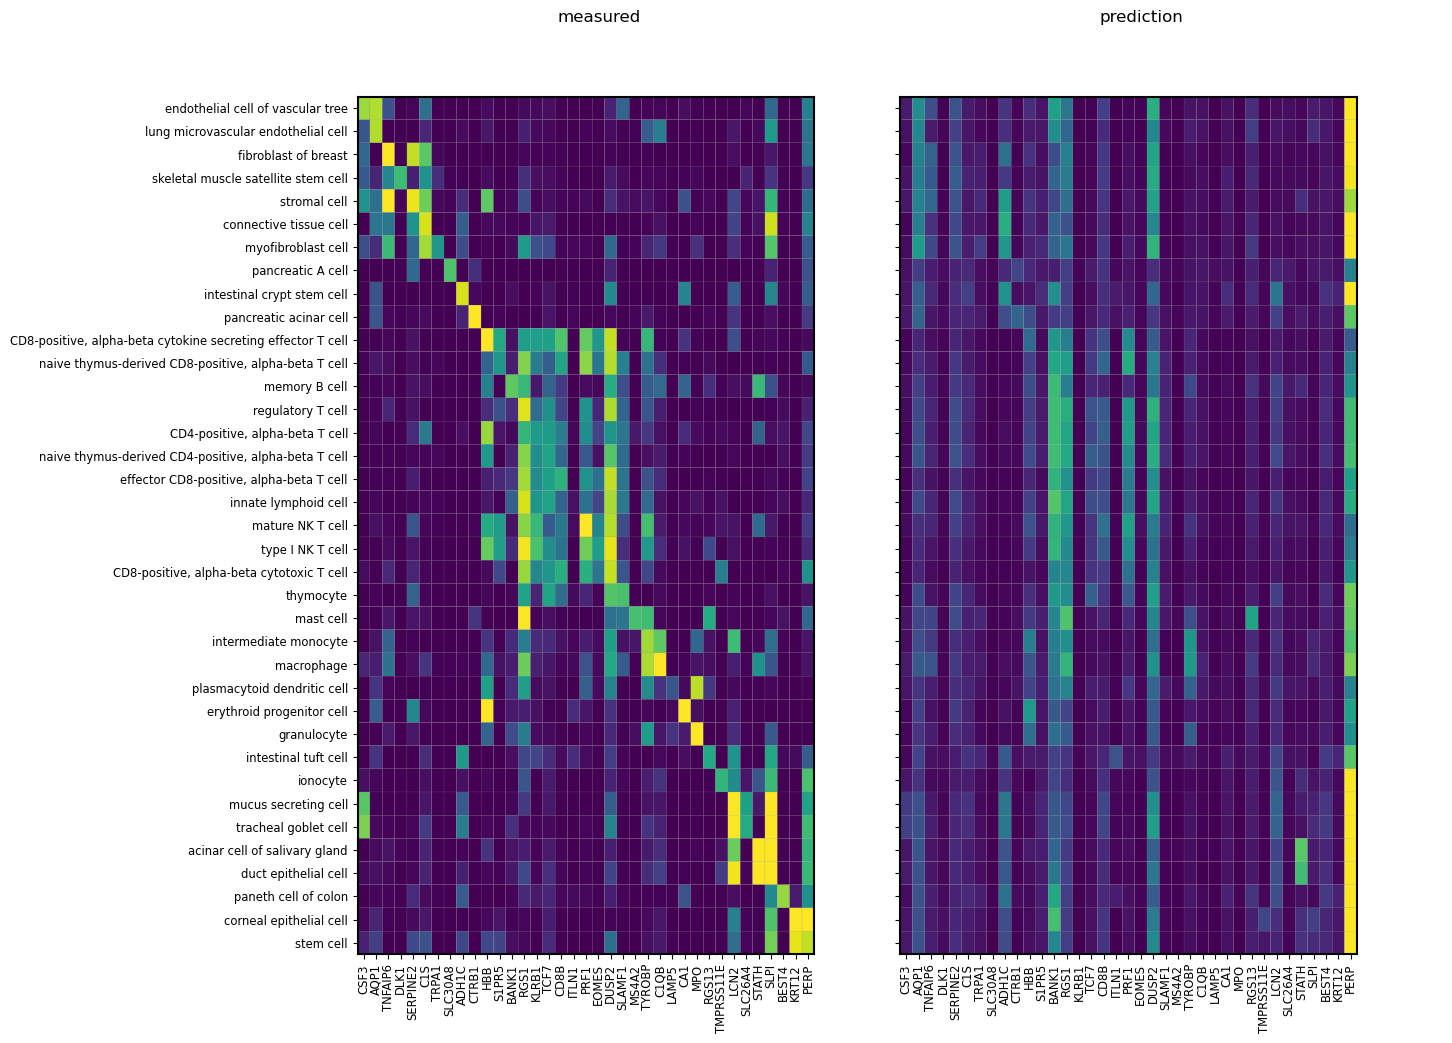

In [6]:
marker_genes_dict = adata_test.obs.set_index('label').to_dict()['marker_feature_name']
plot_marker_gene_heatmap(adata_test, marker_genes_dict)